<a href="https://colab.research.google.com/github/Akankshaaaa/Image-colorization-autoencoders/blob/main/ml_colorize_image.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Image Colorization using Autoencoders**


In [ ]:
%tensorflow_version 1.x

import tensorflow as tf 
print(tf.__version__)
import keras
print(keras.__version__)
!pip install 'h5py<3.0.0'
from keras.layers import Conv2D, UpSampling2D
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from skimage.color import rgb2lab, lab2rgb
from skimage.transform import resize
from skimage.io import imsave
import numpy as np
import matplotlib.pyplot as plt
from keras.optimizers import SGD
import os
os.environ["HDF5_USE_FILE_LOCKING"] = 'FALSE'



TensorFlow 1.x selected.
1.15.2
2.3.1


Using TensorFlow backend.


     |████████████████████████████████| 2.9MB 7.5MB/s 
  Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0


In [ ]:
from google.colab import drive
drive.mount('/content/drive/')


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
%cd /content/drive/MyDrive/mlProject


## **Preprocessing**

In [ ]:
path = '/content/drive/MyDrive/mlProject/Data/'

In [ ]:
#Normalize images - divide by 255
train_datagen = ImageDataGenerator(rescale=1. / 255, horizontal_flip=True)

#Resize images, if needed
train = train_datagen.flow_from_directory(path, 
                                          target_size=(256, 256), 
                                          batch_size=340, 
                                          class_mode=None)

Found 7114 images belonging to 1 classes.


In [ ]:
#convert from RBG to Lab
X =[]
Y =[]
for img in train[0]:
  try:
      lab = rgb2lab(img)
      X.append(lab[:,:,0]) 
      Y.append(lab[:,:,1:] / 128) #A and B values range from -127 to 128, 
      #so we divide the values by 128 to restrict values to between -1 and 1.
  except:
     print('error')
X = np.array(X)
Y = np.array(Y)
X = X.reshape(X.shape+(1,)) #dimensions to be the same for X and Y
print(X.shape)
print(Y.shape)

(340, 256, 256, 1)
(340, 256, 256, 2)


In [ ]:
test_path = '/content/drive/MyDrive/mlProject/test_data/'


In [ ]:
#Normalize images - divide by 255
test_datagen = ImageDataGenerator(rescale=1. / 255)

#Resize images, if needed
test = test_datagen.flow_from_directory(test_path, 
                                          target_size=(256, 256), 
                                          batch_size=340, 
                                          class_mode=None)

Found 86 images belonging to 1 classes.


In [ ]:
#convert from RBG to Lab
X_test =[]
Y_test =[]
for img in test[0]:
  try:
      lab = rgb2lab(img)
      X_test.append(lab[:,:,0]) 
      Y_test.append(lab[:,:,1:] / 128) #A and B values range from -127 to 128, 
      #so we divide the values by 128 to restrict values to between -1 and 1.
  except:
     print('error')
X_test = np.array(X_test)
Y_test = np.array(Y_test)
X_test = X_test.reshape(X_test.shape+(1,)) #dimensions to be the same for X and Y
print(X_test.shape)
print(Y_test.shape)

(86, 256, 256, 1)
(86, 256, 256, 2)


## **Build and train the model**

In [ ]:

#Encoder
model = Sequential()
model.add(Conv2D(64, (3, 3), activation='relu', padding='same', strides=2, input_shape=(256, 256, 1)))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(128, (3,3), activation='relu', padding='same', strides=2))
model.add(Conv2D(256, (3,3), activation='relu', padding='same'))
model.add(Conv2D(256, (3,3), activation='relu', padding='same', strides=2))
model.add(Conv2D(512, (3,3), activation='relu', padding='same'))
model.add(Conv2D(512, (3,3), activation='relu', padding='same'))
model.add(Conv2D(256, (3,3), activation='relu', padding='same'))

#Decoder
model.add(Conv2D(128, (3,3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(32, (3,3), activation='relu', padding='same'))
model.add(Conv2D(16, (3,3), activation='relu', padding='same'))
model.add(Conv2D(2, (3, 3), activation='tanh', padding='same'))
model.add(UpSampling2D((2, 2)))
#opt = SGD(lr=0.008)
model.compile(optimizer=opt, loss='mse' , metrics=['accuracy'])
model.summary()



Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_40 (Conv2D)           (None, 128, 128, 64)      640       
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 128, 128, 128)     73856     
_________________________________________________________________
conv2d_42 (Conv2D)           (None, 64, 64, 128)       147584    
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 64, 64, 256)       295168    
_________________________________________________________________
conv2d_44 (Conv2D)           (None, 32, 32, 256)       590080    
_________________________________________________________________
conv2d_45 (Conv2D)           (None, 32, 32, 512)       1180160   
_________________________________________________________________
conv2d_46 (Conv2D)           (None, 32, 32, 512)      

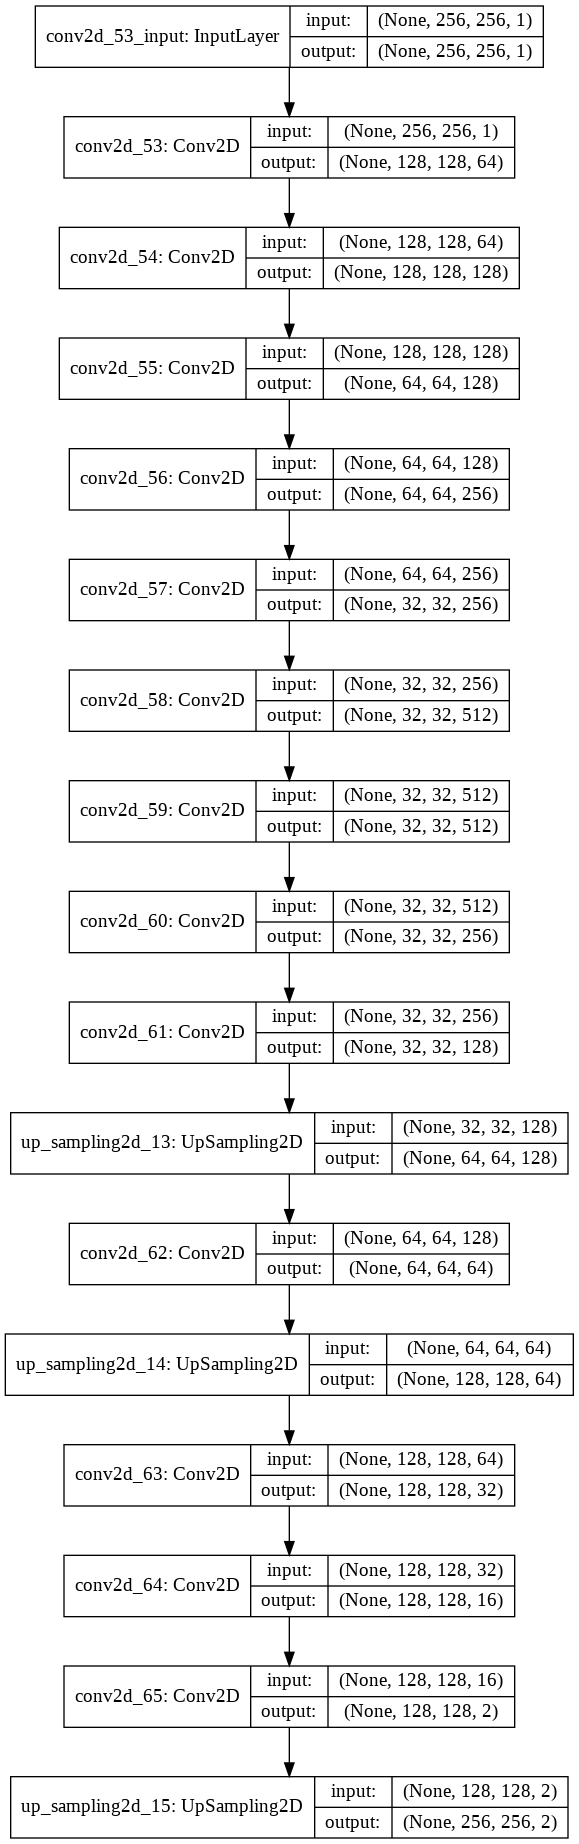

In [ ]:

keras.utils.plot_model(model, "multi_input_and_output_model.png", show_shapes=True)


In [ ]:
#training
history = model.fit(X,Y,validation_split=0.2, epochs=300, batch_size=64)

model.save('/content/sample_data/colorize_autoencoderv21.model')

#plot epochs vs loss and accuracy graphs
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


In [ ]:
#load previous model
model = tf.keras.models.load_model(
    '/content/drive/MyDrive/mlProject/temp1/colorize_autoencoderv21.model',
    custom_objects=None,
    compile=True)


## **Testing**

In [ ]:
# Evaluate accuracy on test data
print("Evaluate on test data")
scores = model.evaluate(X_test, Y_test, verbose=1)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))



In [ ]:
#plot test data prediction results
img1_color=[]
path = '/content/drive/MyDrive/mlProject/test_data/Testing/'

for filename in os.listdir(path):
  img1_color=[]
  img1 = img_to_array(load_img(path+filename))
  print(path+filename)
  img1 = resize(img1 ,(256,256))
  img1_color.append(img1)
  img1_color = np.array(img1_color, dtype=float)
  img1_color = rgb2lab(1.0/255*img1_color)[:,:,:,0]
  img1_color = img1_color.reshape(img1_color.shape+(1,))
  output1 = model.predict(img1_color)
  output1 = output1*128
  result = np.zeros((256, 256, 3))
  result[:,:,0] = img1_color[0][:,:,0]
  result[:,:,1:] = output1[0]
  imsave("/content/drive/MyDrive/mlProject/result/v21img_"+filename+".png", lab2rgb(result))



/content/drive/MyDrive/mlProject/test_data/Testing/23387.jpg


/content/drive/MyDrive/mlProject/test_data/Testing/23401.jpg


/content/drive/MyDrive/mlProject/test_data/Testing/23459.jpg
/content/drive/MyDrive/mlProject/test_data/Testing/23527.jpg


/content/drive/MyDrive/mlProject/test_data/Testing/23576.jpg


/content/drive/MyDrive/mlProject/test_data/Testing/23457.jpg
/content/drive/MyDrive/mlProject/test_data/Testing/23603.jpg


/content/drive/MyDrive/mlProject/test_data/Testing/23643.jpg
/content/drive/MyDrive/mlProject/test_data/Testing/23861.jpg


/content/drive/MyDrive/mlProject/test_data/Testing/23725.jpg


/content/drive/MyDrive/mlProject/test_data/Testing/23833.jpg


/content/drive/MyDrive/mlProject/test_data/Testing/23965.jpg


/content/drive/MyDrive/mlProject/test_data/Testing/23933.jpg
/content/drive/MyDrive/mlProject/test_data/Testing/23997.jpg


/content/drive/MyDrive/mlProject/test_data/Testing/23959.jpg


/content/drive/MyDrive/mlProject/test_data/Testing/23978.jpg


/content/drive/MyDrive/mlProject/test_data/Testing/24139.jpg
/content/drive/MyDrive/mlProject/test_data/Testing/24086.jpg


/content/drive/MyDrive/mlProject/test_data/Testing/24052.jpg


/content/drive/MyDrive/mlProject/test_data/Testing/24242.jpg
/content/drive/MyDrive/mlProject/test_data/Testing/24313.jpg


/content/drive/MyDrive/mlProject/test_data/Testing/24269.jpg
/content/drive/MyDrive/mlProject/test_data/Testing/24311.jpg


/content/drive/MyDrive/mlProject/test_data/Testing/24249.jpg


/content/drive/MyDrive/mlProject/test_data/Testing/24214.jpg


/content/drive/MyDrive/mlProject/test_data/Testing/24219.jpg


/content/drive/MyDrive/mlProject/test_data/Testing/24215.jpg
/content/drive/MyDrive/mlProject/test_data/Testing/1179.jpg


/content/drive/MyDrive/mlProject/test_data/Testing/1404.jpg


/content/drive/MyDrive/mlProject/test_data/Testing/2763.jpg


/content/drive/MyDrive/mlProject/test_data/Testing/266.jpg


/content/drive/MyDrive/mlProject/test_data/Testing/2711.jpg
/content/drive/MyDrive/mlProject/test_data/Testing/2715.jpg


/content/drive/MyDrive/mlProject/test_data/Testing/2762.jpg


/content/drive/MyDrive/mlProject/test_data/Testing/2693.jpg


/content/drive/MyDrive/mlProject/test_data/Testing/2987.jpg
/content/drive/MyDrive/mlProject/test_data/Testing/2992.jpg


/content/drive/MyDrive/mlProject/test_data/Testing/2982.jpg


/content/drive/MyDrive/mlProject/test_data/Testing/2983.jpg


/content/drive/MyDrive/mlProject/test_data/Testing/2978.jpg
/content/drive/MyDrive/mlProject/test_data/Testing/2986.jpg


/content/drive/MyDrive/mlProject/test_data/Testing/2988.jpg
/content/drive/MyDrive/mlProject/test_data/Testing/2980.jpg


/content/drive/MyDrive/mlProject/test_data/Testing/298.jpg


/content/drive/MyDrive/mlProject/test_data/Testing/387.jpg


/content/drive/MyDrive/mlProject/test_data/Testing/2993.jpg


/content/drive/MyDrive/mlProject/test_data/Testing/2977.jpg
/content/drive/MyDrive/mlProject/test_data/Testing/2990.jpg


/content/drive/MyDrive/mlProject/test_data/Testing/2994.jpg
/content/drive/MyDrive/mlProject/test_data/Testing/2991.jpg


/content/drive/MyDrive/mlProject/test_data/Testing/2976.jpg


/content/drive/MyDrive/mlProject/test_data/Testing/2984.jpg
/content/drive/MyDrive/mlProject/test_data/Testing/2979.jpg


/content/drive/MyDrive/mlProject/test_data/Testing/323.jpg
/content/drive/MyDrive/mlProject/test_data/Testing/2981.jpg


/content/drive/MyDrive/mlProject/test_data/Testing/2985.jpg
/content/drive/MyDrive/mlProject/test_data/Testing/2975.jpg


/content/drive/MyDrive/mlProject/test_data/Testing/2989.jpg
/content/drive/MyDrive/mlProject/test_data/Testing/5795.jpg


/content/drive/MyDrive/mlProject/test_data/Testing/5759.jpg
/content/drive/MyDrive/mlProject/test_data/Testing/5743.jpg


/content/drive/MyDrive/mlProject/test_data/Testing/6685.jpg


/content/drive/MyDrive/mlProject/test_data/Testing/5727.jpg
/content/drive/MyDrive/mlProject/test_data/Testing/567.jpg


/content/drive/MyDrive/mlProject/test_data/Testing/6203.jpg


/content/drive/MyDrive/mlProject/test_data/Testing/5659.jpg


/content/drive/MyDrive/mlProject/test_data/Testing/5640.jpg
/content/drive/MyDrive/mlProject/test_data/Testing/6802.jpg


/content/drive/MyDrive/mlProject/test_data/Testing/6825.jpg


/content/drive/MyDrive/mlProject/test_data/Testing/6821.jpg


/content/drive/MyDrive/mlProject/test_data/Testing/897.jpg


/content/drive/MyDrive/mlProject/test_data/Testing/6826.jpg


/content/drive/MyDrive/mlProject/test_data/Testing/6833.jpg
/content/drive/MyDrive/mlProject/test_data/Testing/6832.jpg


/content/drive/MyDrive/mlProject/test_data/Testing/6827.jpg


/content/drive/MyDrive/mlProject/test_data/Testing/6829.jpg
/content/drive/MyDrive/mlProject/test_data/Testing/6822.jpg


/content/drive/MyDrive/mlProject/test_data/Testing/6823.jpg


/content/drive/MyDrive/mlProject/test_data/Testing/6720.jpg


/content/drive/MyDrive/mlProject/test_data/Testing/6828.jpg


/content/drive/MyDrive/mlProject/test_data/Testing/6770.jpg


/content/drive/MyDrive/mlProject/test_data/Testing/6782.jpg
/content/drive/MyDrive/mlProject/test_data/Testing/6834.jpg


/content/drive/MyDrive/mlProject/test_data/Testing/6831.jpg


/content/drive/MyDrive/mlProject/test_data/Testing/6731.jpg
/content/drive/MyDrive/mlProject/test_data/Testing/24000.jpg
